In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import csv
import itertools
import os
import random
import re
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from PIL import Image, ImageFilter


In [30]:
import shutil

# Define directories
TRAIN_DIR_PATH = r"/kaggle/input/dogs-vs-cats/train/train"
TEST_DIR_PATH = r'/kaggle/input/dogs-vs-cats/test/test'
file_names = os.listdir(TRAIN_DIR_PATH)
print(len(file_names))
# # Create subdirectories for cats and dogs in the training directory
# cats_dir = train_dir / 'cats'
# dogs_dir = train_dir / 'dogs'
# cats_dir.mkdir(exist_ok=True)
# dogs_dir.mkdir(exist_ok=True)

# # Move images to the respective subdirectories
# for filename in train_dir.iterdir():
#     if filename.is_file():
#         if 'cat' in filename.name.lower():
#             shutil.move(str(filename), str(cats_dir / filename.name))
#         elif 'dog' in filename.name.lower():
#             shutil.move(str(filename), str(dogs_dir / filename.name))

25000


In [4]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_paths, targets, transform=None):
        self.file_paths = file_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
# Prepare dataset
IMAGE_FOLDER_PATH = "/kaggle/input/dogs-vs-cats/train/train"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)

len(FILE_NAMES)

25000

In [12]:
targets = []
full_paths = []
train_cats_dir = []
train_dogs_dir = []

In [13]:
# Finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0]  # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if target == "dog":
        train_dogs_dir.append(full_path)
    if target == "cat":
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(1 if target == "dog" else 0)

In [14]:
dataset = pd.DataFrame()  # make dataframe
dataset['image_path'] = full_paths  # file path
dataset['target'] = targets  # file's target

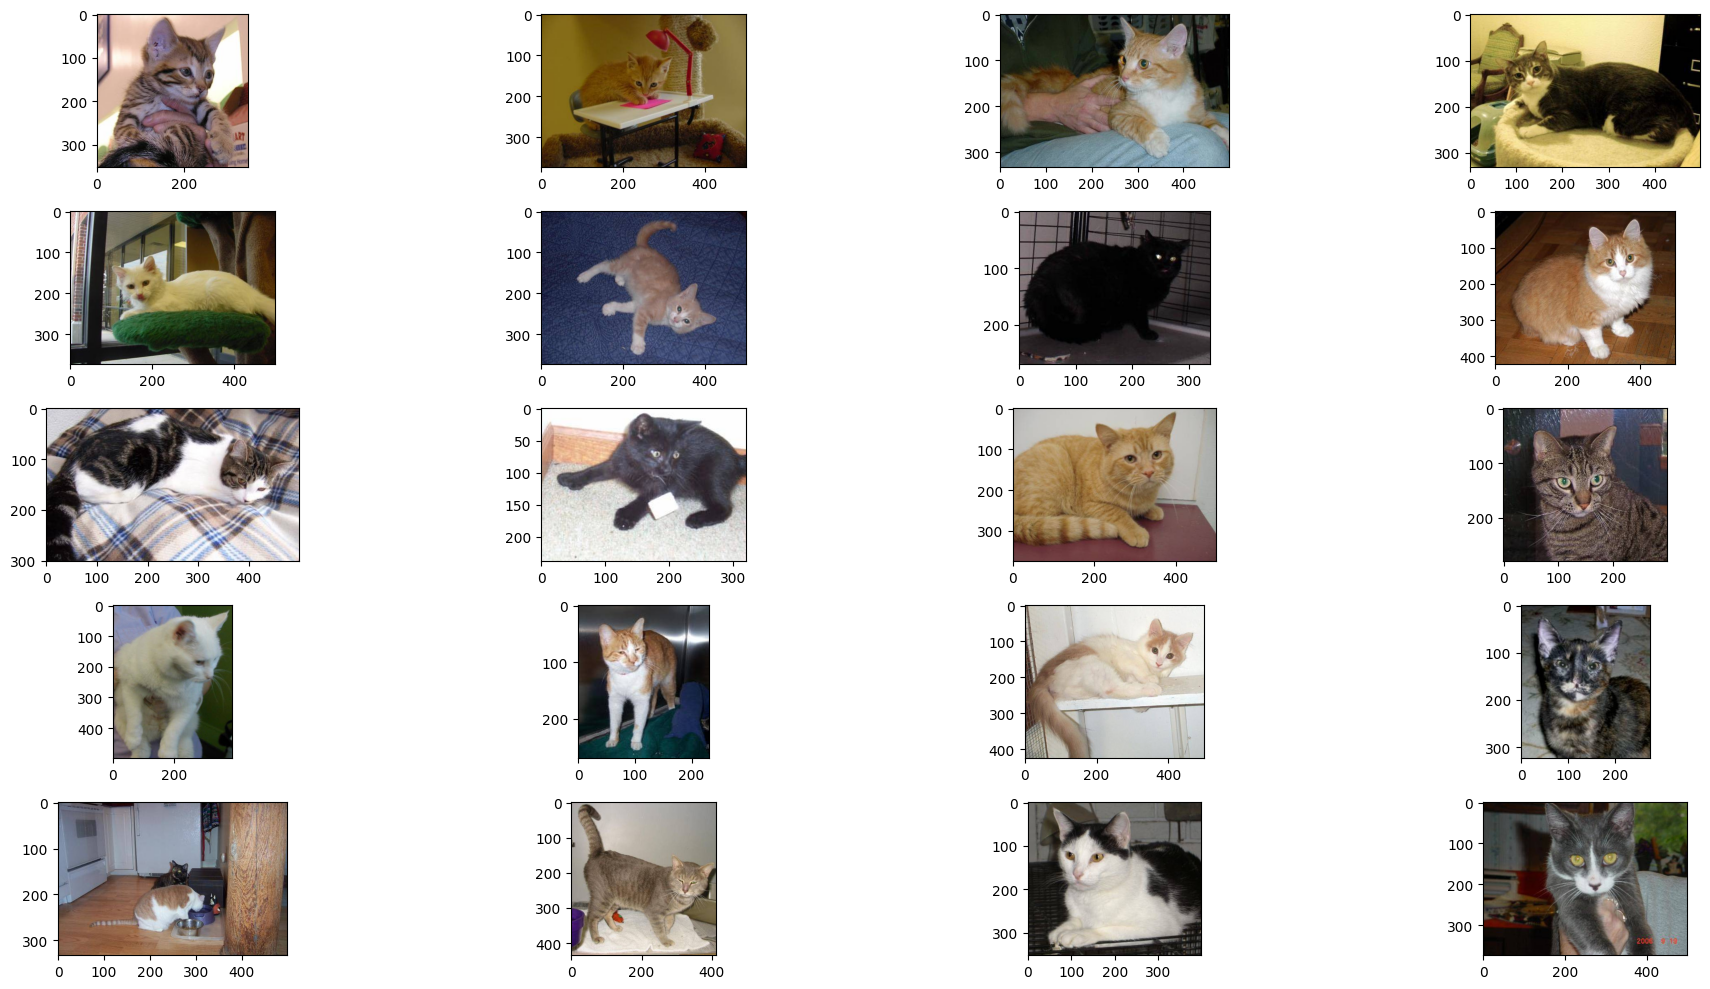

In [16]:
# Visualization
rows, cols = 5, 4
fig = plt.figure(figsize=(20, 10))

for i in range(rows * cols):
    img_path = train_cats_dir[i]
    img = mpimg.imread(img_path)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img)

fig.tight_layout()
plt.show()

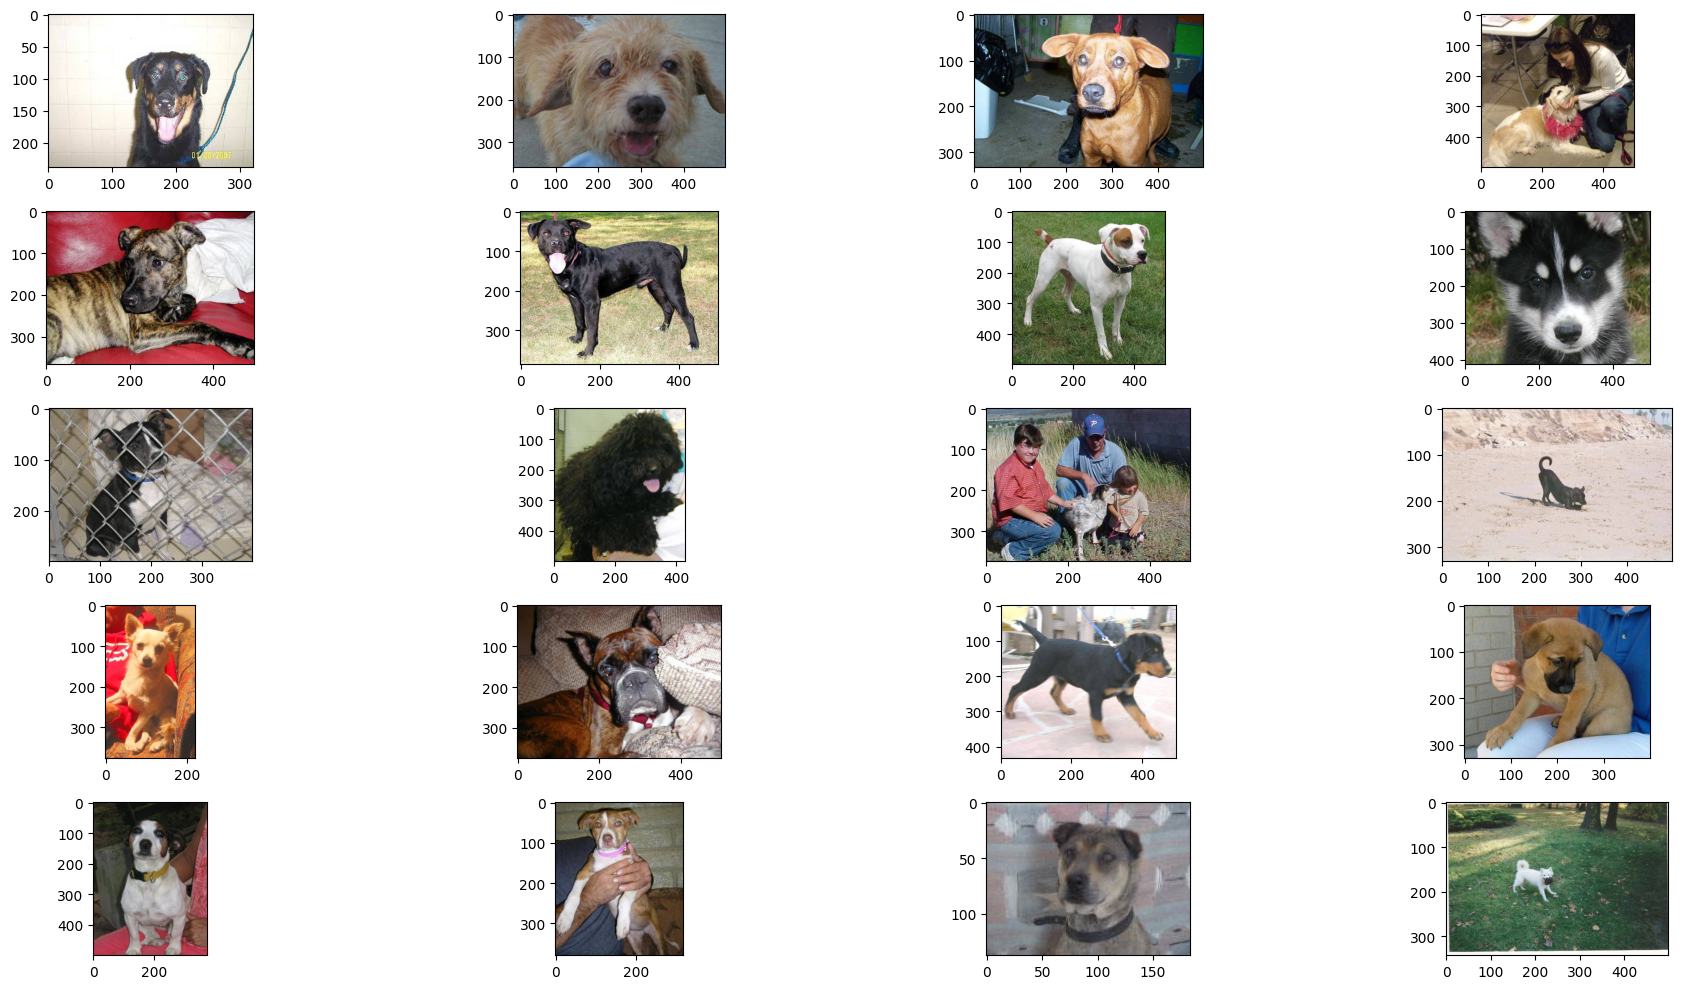

In [17]:
fig = plt.figure(figsize=(20, 10))

for i in range(rows * cols):
    img_path = train_dogs_dir[i]
    img = mpimg.imread(img_path)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img)

fig.tight_layout()
plt.show()

In [18]:
# Train-test split
train_size = int(0.8 * len(dataset))
test_val_size = len(dataset) - train_size
test_size = int(0.5 * test_val_size)
val_size = test_val_size - test_size

In [19]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

In [20]:
# Dataset and DataLoader
cats_dogs_dataset = CatsDogsDataset(dataset['image_path'].tolist(), dataset['target'].tolist(), transform=transform)
train_dataset, test_val_dataset = random_split(cats_dogs_dataset, [train_size, test_val_size])
test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [23]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch 1, Loss: 0.6445, Accuracy: 63.34%
Epoch 2, Loss: 0.5372, Accuracy: 72.90%
Epoch 3, Loss: 0.4696, Accuracy: 77.55%
Epoch 4, Loss: 0.4121, Accuracy: 81.30%
Epoch 5, Loss: 0.3344, Accuracy: 85.27%
Epoch 6, Loss: 0.2398, Accuracy: 90.19%
Epoch 7, Loss: 0.1431, Accuracy: 94.61%
Epoch 8, Loss: 0.0905, Accuracy: 96.81%
Epoch 9, Loss: 0.0594, Accuracy: 98.09%
Epoch 10, Loss: 0.0446, Accuracy: 98.55%


In [28]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 78.08%


In [31]:
# Submission
test_images = [os.path.join(TEST_DIR_PATH, i) for i in os.listdir(TEST_DIR_PATH)]
test_dataset = CatsDogsDataset(test_images, [0] * len(test_images), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.cpu().numpy())

test_predictions_mapped = [1 if label == 1 else 0 for label in test_predictions]
predictions_df = pd.DataFrame({'id': range(1, len(test_predictions_mapped) + 1), 'label': test_predictions_mapped})
predictions_df.to_csv('pytorch_test_predictions.csv', index=False)

predictions_df.head()

,id,label
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0
